In [33]:
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import os
import sys

path_to_this_notebook = os.path.abspath('.')
path_to_project = path_to_this_notebook[:path_to_this_notebook.find('note')]
sys.path.append(path_to_project)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
from src.td3_code.agents.td3 import TD3Agent
from src.td3_code.memory.trajectory_replay_buffer import TrajectoryMemoryBuffer
from src.td3_code.memory.transition_replay_buffer import TransitionMemoryBuffer
from src.td3_code.runners.runner import Runner

from src.samplers.load_samplers import load_samplers
from src.environments.create_env import create_env

In [35]:
import numpy as np 
import gym
# create and initialize the environment
# env = gym.make("Pendulum-v1")

### Environment stuff

In [36]:
config = {'path_to_data': './data/', 
          't0_hr': 6., # When the episode start (default value 6AM)
          'dt_min': 30, # Timestep size
          'ev_dt_min': 60, # Timestep size for EV arrivals
          'ev_sampling_dt_min': 60,  # How EV sessions are sampled from the data
          'apply_gaussian_noise': False, # Make data noisy
          'ev_utility_coef_mean': 1, # Mean value of the utility coefficient for the EVs
          'ev_utility_coef_scale': 0.13, # STD of the utility coefficient for the EVs
          'days_per_month_train': 20, # Days per month for training 
          'ev_session_months_train': ['01', '02', '03', '04', '06', '07', '08', '09', '10', '11',],
           # Months to sample EV sessions for training 
          'grid_to_use': 'ieee16', # What grid topology to use. Now supports only IEEE16. 
          'ev_session_months_test': ['05', '12'], # Months to sample EV sessions for test 
          'n_ps_pvs': 4, # Amount of solar panels that use PecanStreet data
          'n_canopy_pvs': 0, # Amount of solar panels that use canopy data
          'canopy_pv_rated_power': 250, # Rated power of these panels
          'n_loads': 0, # Amount of inflexible loads
          'n_feeders': 1, # Amount of feeders
          'n_ev_chargers': 4, # Amount of EV chargers
          
          'ps_pvs_rated_power': 4, # Rated power of these panels
          'avg_evs_per_day': 3.5, # Scaling of the EV arrival rate
          'feeder_p_min': -5, # Capacity of the feeders
          'g': 4, # Conductance of each line
          'i_max': 25, # Capacity of each line
          # new and improved cool config options
          'environment_type': 'normal', # normal / gym
          'epochs': 15,
          }

In [37]:
# Preload samplers, it is necessary to avoid re-loading data each time env is created
(ps_samplers_dict, ps_metadata, canopy_sampler, canopy_metadata,
 price_sampler, price_metadata, ev_sampler, elaadnl_metadata) = load_samplers(config)

{'path_to_data': './data/', 't0_hr': 6.0, 'dt_min': 30, 'ev_dt_min': 60, 'ev_sampling_dt_min': 60, 'apply_gaussian_noise': False, 'ev_utility_coef_mean': 1, 'ev_utility_coef_scale': 0.13, 'days_per_month_train': 20, 'ev_session_months_train': ['01', '02', '03', '04', '06', '07', '08', '09', '10', '11'], 'grid_to_use': 'ieee16', 'ev_session_months_test': ['05', '12'], 'n_ps_pvs': 4, 'n_canopy_pvs': 0, 'canopy_pv_rated_power': 250, 'n_loads': 0, 'n_feeders': 1, 'n_ev_chargers': 4, 'ps_pvs_rated_power': 4, 'avg_evs_per_day': 3.5, 'feeder_p_min': -5, 'g': 4, 'i_max': 25, 'environment_type': 'normal', 'epochs': 15}


In [38]:
# Create environment
env = create_env(config, ps_samplers_dict, ps_metadata, canopy_sampler, canopy_metadata,
                 price_sampler, price_metadata, ev_sampler, elaadnl_metadata)
env.plot_grid(bbox=(0, 0, 500, 500))

KeyError: 'device_constraint_violation_mode'

In [ ]:
# set environment type to gym for the next sections
config['environment_type'] = 'gym'

def env_creator(a):
    (ps_samplers_dict, ps_metadata, canopy_sampler, canopy_metadata,
     price_sampler, price_metadata, ev_sampler, elaadnl_metadata) = load_samplers(config)

    return create_env(
        config,
        ps_samplers_dict,
        ps_metadata,
        canopy_sampler,
        canopy_metadata,
        price_sampler,
        price_metadata,
        ev_sampler,
        elaadnl_metadata
    )
register_env("my_env", env_creator)

In [ ]:
env.action_space, env.observation_space

In [ ]:
observation_dim = env.observation_space.shape[0]
action_dim =  env.action_space.shape[0]
max_action_value = env.action_space.high[0]
scheme = {'observations': env.observation_space.shape, 
          'observations_next': env.observation_space.shape,
          'actions': env.action_space.shape,
          'done': (1, ), 'reward': (1, ), 'reset_mask': (1, )}

### Normal transitions

In [ ]:
memory_trans = TransitionMemoryBuffer(scheme=scheme, max_size=int(1e6), min_size_to_sample=2000, 
                                      sample_during_episode=True)


memory_traj = TrajectoryMemoryBuffer(scheme=scheme, max_size=int(1e6/200), min_size_to_sample=10, 
                                     use_transitions=False, sample_during_episode=False)

memory_traj_trans = TrajectoryMemoryBuffer(scheme=scheme, max_size=int(1e6/200), min_size_to_sample=10, 
                                          use_transitions=True, sample_during_episode=True)



lstm_dims_list = []
hidden_dims_list = [64, 64]

agent = TD3Agent(observation_dim, action_dim, max_action_value, lstm_dims_list, hidden_dims_list,
                 actor_lr=8e-4, critic_lr=8e-4,  discount=0.99, tau=0.005,
                 policy_noise=0.2, noise_clip=0.5, policy_update_freq=2)

runner = Runner(env, memory_trans, agent)

batch_size = 16

In [ ]:
n_eps = 1001
print_each = 50
test_each = 50
n_test_episodes = 10

keys_to_print = ['reward']
train_results = defaultdict(list)
test_results = defaultdict(list)

for ep in range(1, n_eps):
    #print('            EP%d' % ep)
    episode_results = runner.run(train=True, save_to_memory=True, train_bath_size=batch_size)
    for key, val in episode_results.items():
        train_results[key].append(val)
    
    if ep % print_each == 0:
        print('Training episode %d    ' % ep)
        for key in keys_to_print:
            print('    %s=%.2f' % (key, np.mean(train_results[key][-print_each:])))
        print()
        
    if ep % test_each == 0:
        current_test_results = defaultdict(list)
        for test_ep in range(n_test_episodes):
            episode_results = runner.run(train=False, save_to_memory=False)
            for key, val in episode_results.items():
                current_test_results[key].append(val)
        current_test_results = {key: np.mean(val) for key, val in current_test_results.items()}
        for key, val in current_test_results.items():
            test_results[key].append(val)
            
        print('Test run after episode %d:' % ep)
        for key in keys_to_print:
            print('    %s=%.2f' % (key, current_test_results[key]))
        print()
        

In [ ]:
plt.plot(train_results['reward'])

### Transitions from the Traj buffer

In [ ]:
memory_trans = TransitionMemoryBuffer(scheme=scheme, max_size=int(1e6), min_size_to_sample=2000, 
                                      sample_during_episode=True)


memory_traj = TrajectoryMemoryBuffer(scheme=scheme, max_size=int(1e6/200), min_size_to_sample=10, 
                                     use_transitions=False, sample_during_episode=False)

memory_traj_trans = TrajectoryMemoryBuffer(scheme=scheme, max_size=int(1e6/200), min_size_to_sample=10, 
                                          use_transitions=True, sample_during_episode=True)



lstm_dims_list = []
hidden_dims_list = [64, 64]

agent = TD3Agent(observation_dim, action_dim, max_action_value, lstm_dims_list, hidden_dims_list,
                 actor_lr=8e-4, critic_lr=8e-4,  discount=0.99, tau=0.005,
                 policy_noise=0.2, noise_clip=0.5, policy_update_freq=2)

runner = Runner(env, memory_traj_trans, agent)

batch_size = 16

In [ ]:
n_eps = 1001
print_each = 50
test_each = 50
n_test_episodes = 10

keys_to_print = ['reward']
train_results = defaultdict(list)
test_results = defaultdict(list)

for ep in range(1, n_eps):
    #print('            EP%d' % ep)
    episode_results = runner.run(train=True, save_to_memory=True, train_bath_size=batch_size)
    for key, val in episode_results.items():
        train_results[key].append(val)
    
    if ep % print_each == 0:
        print('Training episode %d    ' % ep)
        for key in keys_to_print:
            print('    %s=%.2f' % (key, np.mean(train_results[key][-print_each:])))
        print()
        
    if ep % test_each == 0:
        current_test_results = defaultdict(list)
        for test_ep in range(n_test_episodes):
            episode_results = runner.run(train=False, save_to_memory=False)
            for key, val in episode_results.items():
                current_test_results[key].append(val)
        current_test_results = {key: np.mean(val) for key, val in current_test_results.items()}
        for key, val in current_test_results.items():
            test_results[key].append(val)
            
        print('Test run after episode %d:' % ep)
        for key in keys_to_print:
            print('    %s=%.2f' % (key, current_test_results[key]))
        print()
        

In [ ]:
plt.plot(test_results['reward'])

###  Transitions from the Traj buffer, learning after episode

In [16]:
memory_trans = TransitionMemoryBuffer(scheme=scheme, max_size=int(1e6), min_size_to_sample=2000, 
                                      sample_during_episode=True)


memory_traj = TrajectoryMemoryBuffer(scheme=scheme, max_size=int(1e6/200), min_size_to_sample=10, 
                                     use_transitions=False, sample_during_episode=False)

memory_traj_trans = TrajectoryMemoryBuffer(scheme=scheme, max_size=int(1e6/200), min_size_to_sample=10, 
                                          use_transitions=True, sample_during_episode=False)



lstm_dims_list = []
hidden_dims_list = [64, 64]

agent = TD3Agent(observation_dim, action_dim, max_action_value, lstm_dims_list, hidden_dims_list,
                 actor_lr=8e-4, critic_lr=8e-4,  discount=0.99, tau=0.05,
                 policy_noise=0.2, noise_clip=0.5, policy_update_freq=2)

runner = Runner(env, memory_traj_trans, agent)

batch_size =  512

In [17]:
n_eps = 50401
print_each = 50
test_each = 50
n_test_episodes = 10

keys_to_print = ['reward']
train_results = defaultdict(list)
test_results = defaultdict(list)

for ep in range(1, n_eps):
    #print('            EP%d' % ep)
    episode_results = runner.run(train=True, save_to_memory=True, train_bath_size=batch_size)
    for key, val in episode_results.items():
        train_results[key].append(val)
    
    if ep % print_each == 0:
        print('Training episode %d    ' % ep)
        for key in keys_to_print:
            print('    %s=%.2f' % (key, np.mean(train_results[key][-print_each:])))
        print()
        
    if ep % test_each == 0:
        current_test_results = defaultdict(list)
        for test_ep in range(n_test_episodes):
            episode_results = runner.run(train=False, save_to_memory=False)
            for key, val in episode_results.items():
                current_test_results[key].append(val)
        current_test_results = {key: np.mean(val) for key, val in current_test_results.items()}
        for key, val in current_test_results.items():
            test_results[key].append(val)
            
        print('Test run after episode %d:' % ep)
        for key in keys_to_print:
            print('    %s=%.2f' % (key, current_test_results[key]))
        print()
        

Training episode 50    
    reward=-1377.13

Test run after episode 50:
    reward=-1513.93

Training episode 100    
    reward=-1483.78

Test run after episode 100:
    reward=-1444.76

Training episode 150    
    reward=-1437.30

Test run after episode 150:
    reward=-1455.90

Training episode 200    
    reward=-1553.14

Test run after episode 200:
    reward=-1617.54

Training episode 250    
    reward=-1579.45

Test run after episode 250:
    reward=-1544.72

Training episode 300    
    reward=-1541.50

Test run after episode 300:
    reward=-1515.58

Training episode 350    
    reward=-1548.85

Test run after episode 350:
    reward=-1425.22

Training episode 400    
    reward=-1515.86

Test run after episode 400:
    reward=-1474.32

Training episode 450    
    reward=-1521.43

Test run after episode 450:
    reward=-1415.02

Training episode 500    
    reward=-1496.12

Test run after episode 500:
    reward=-1478.80

Training episode 550    
    reward=-1421.24

Test r

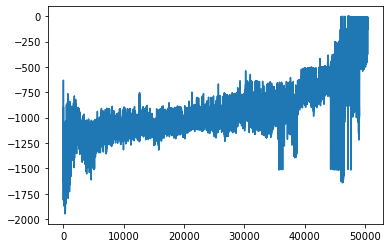

In [18]:
plt.plot(train_results['reward'])

###  Trajectories from the Traj buffer, learning after episode

In [28]:
memory_trans = TransitionMemoryBuffer(scheme=scheme, max_size=int(1e6), min_size_to_sample=2000, 
                                      sample_during_episode=True)


memory_traj = TrajectoryMemoryBuffer(scheme=scheme, max_size=int(1e6/200), min_size_to_sample=10, 
                                     use_transitions=False, sample_during_episode=True)

memory_traj_trans = TrajectoryMemoryBuffer(scheme=scheme, max_size=int(1e6/200), min_size_to_sample=10, 
                                          use_transitions=True, sample_during_episode=False)



lstm_dims_list = [64]
hidden_dims_list = [64]

agent = TD3Agent(observation_dim, action_dim, max_action_value, lstm_dims_list, hidden_dims_list,
                 actor_lr=8e-4, critic_lr=8e-4,  discount=0.99, tau=0.05,
                 policy_noise=0.2, noise_clip=0.5, policy_update_freq=2)

runner = Runner(env, memory_traj, agent)

batch_size =  1

In [29]:
n_eps = 150401
print_each = 5
test_each = 50
n_test_episodes = 10

keys_to_print = ['reward']
train_results = defaultdict(list)
test_results = defaultdict(list)

for ep in range(1, n_eps):
    #print('            EP%d' % ep)
    episode_results = runner.run(train=True, save_to_memory=True, train_bath_size=batch_size)
    for key, val in episode_results.items():
        train_results[key].append(val)
    
    if ep % print_each == 0:
        print('Training episode %d    ' % ep)
        for key in keys_to_print:
            print('    %s=%.2f' % (key, np.mean(train_results[key][-print_each:])))
        print()
        
    if ep % test_each == 0:
        current_test_results = defaultdict(list)
        for test_ep in range(n_test_episodes):
            episode_results = runner.run(train=False, save_to_memory=False)
            for key, val in episode_results.items():
                current_test_results[key].append(val)
        current_test_results = {key: np.mean(val) for key, val in current_test_results.items()}
        for key, val in current_test_results.items():
            test_results[key].append(val)
            
        print('Test run after episode %d:' % ep)
        for key in keys_to_print:
            print('    %s=%.2f' % (key, current_test_results[key]))
        print()
        

Training episode 5    
    reward=-202.93



/home/gr1/miniconda3/envs/pytorch/lib/python3.7/site-packages/torch/nn/modules/rnn.py:680: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:924.)
  self.dropout, self.training, self.bidirectional, self.batch_first)


Training episode 10    
    reward=-104.30

Training episode 15    
    reward=-782.68

Training episode 20    
    reward=-532.24

Training episode 25    
    reward=-361.34

Training episode 30    
    reward=-100.95

Training episode 35    
    reward=-658.72

Training episode 40    
    reward=-679.04

Training episode 45    
    reward=-275.52

Training episode 50    
    reward=-58.77

Test run after episode 50:
    reward=-168.52

Training episode 55    
    reward=-22.50

Training episode 60    
    reward=-50.02

Training episode 65    
    reward=-99.35

Training episode 70    
    reward=-337.15

Training episode 75    
    reward=-230.45

Training episode 80    
    reward=-89.41

Training episode 85    
    reward=-143.34

Training episode 90    
    reward=-207.69

Training episode 95    
    reward=-226.71

Training episode 100    
    reward=-206.16

Test run after episode 100:
    reward=-243.33



KeyboardInterrupt: 

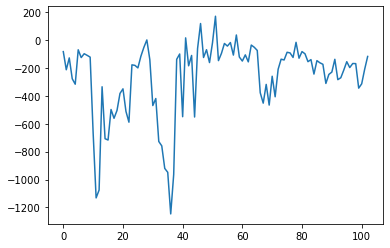

In [32]:
plt.plot(train_results['reward'])

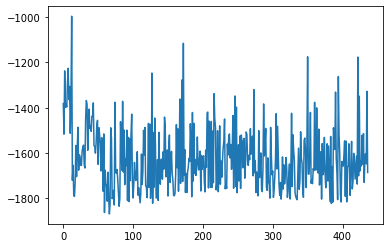

In [33]:
plt.plot(train_results['reward'])